In [3]:
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

ss_file_name = "/home/cshah/workspaces/sensorsuit/quat_debug/08_07_2025/08_07_shank.csv"
vicon_file_name = "/home/cshah/workspaces/sensorsuit/quat_debug/VIcon_08_08/ext_shank_01.csv"

In [4]:
vicon_df = pd.read_csv(vicon_file_name)

# Step 2: Extract coordinates
C1 = vicon_df[["C1_x", "C1_y", "C1_z"]].values
X1 = vicon_df[["X1_x", "X1_y", "X1_z"]].values
Y1 = vicon_df[["Y1_x", "Y1_y", "Y1_z"]].values
n_frames = C1.shape[0]

# Step 3: Build the initial local frame (t=0)
def build_frame(C, X, Y):
    x_axis = X - C
    x_axis /= np.linalg.norm(x_axis)
    
    y_axis = Y - C
    y_axis /= np.linalg.norm(y_axis)
    
    # y_temp = Y - C
    z_axis = np.cross(x_axis, y_axis)
    z_axis /= np.linalg.norm(z_axis)
    
    # y_axis = np.cross(z_axis, x_axis)
    # y_axis /= np.linalg.norm(y_axis)
    
    # Rotation matrix: columns are basis vectors
    return np.stack([x_axis, y_axis, z_axis], axis=1)

R0 = build_frame(C1[0], X1[0], Y1[0])  # initial local frame (3x3)

# Step 4: For each frame, compute relative rotation to R0
euler_angles = []  # each row: [roll (X), pitch (Y), yaw (Z)]

for t in range(n_frames):
    Rt = build_frame(C1[t], X1[t], Y1[t])  # current frame
    R_rel = Rt @ R0.T  # rotation from R0 to Rt
    rot = R.from_matrix(R_rel)
    
    # You can choose any convention: "xyz" or "zyx" depending on your definition
    angles = rot.as_euler("xyz", degrees=True)  # roll, pitch, yaw
    euler_angles.append(angles)

vicon_euler_angles = np.array(euler_angles)



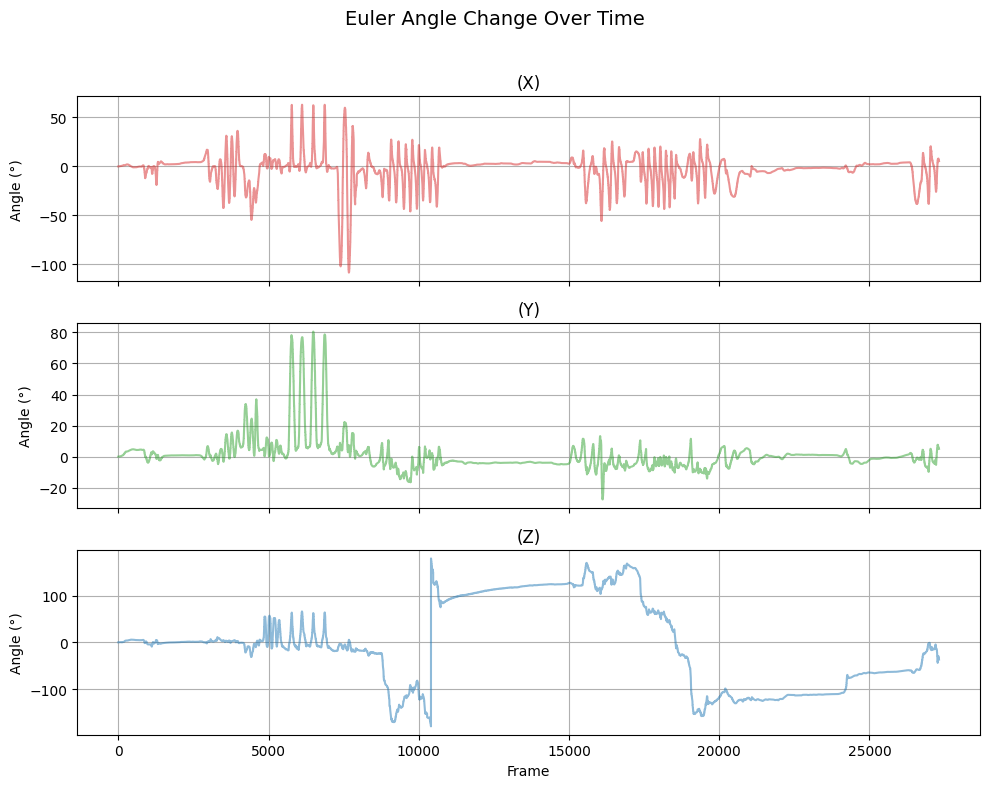

In [ ]:
ss_df = pd.read_csv(ss_file_name)

# imu_name = "imu4_quat"
# sync_start_index = ss_df[(ss_df['SYNC'].shift(1) == 0) & (ss_df['SYNC'] == 1)].index

# data_start = sync_start_index[0]
# data_end = sync_start_index[1]


imu_quat = np.stack(ss_df["imu5_quat"].iloc[2:].apply(eval).values)
imu_Filtquat = np.stack(ss_df["imu5_ESTquat"].iloc[2:].apply(eval).values)

# zero the imu to the first frame and 
imu_0 = imu_quat[0]
imu_filt0 = imu_Filtquat[0]

rel_imu = R.from_quat(imu_quat, scalar_first=True) * R.from_quat(imu_0, scalar_first=True).inv() 
rel_imu_filt =  R.from_quat(imu_Filtquat, scalar_first=True) *  R.from_quat(imu_filt0, scalar_first=True).inv()

euler_angles = rel_imu.as_euler('xyz', degrees=True)
euler_angles_filt = rel_imu_filt.as_euler('xyz', degrees=True)


# Time axis
time = np.arange(euler_angles.shape[0])

# Labels for each axis
angle_labels = ['(X)', '(Y)', '(Z)']
colors = ['tab:red', 'tab:green', 'tab:blue']


# Create 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i in range(3):
    f = 1
    # if i ==1 or i==2:
    #     f = -1

    axes[i].plot(time, f * euler_angles[:, i], color=colors[i], label="IMU")
    axes[i].plot(time, euler_angles_filt[:, i], color=colors[i], alpha = 0.5, label="IMU Filt")
    axes[i].set_ylabel("Angle (°)")
    axes[i].set_title(angle_labels[i])
    axes[i].grid(True)

axes[-1].set_xlabel("Frame")
plt.suptitle("Euler Angle Change Over Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Upsampled shape: (3576, 3)


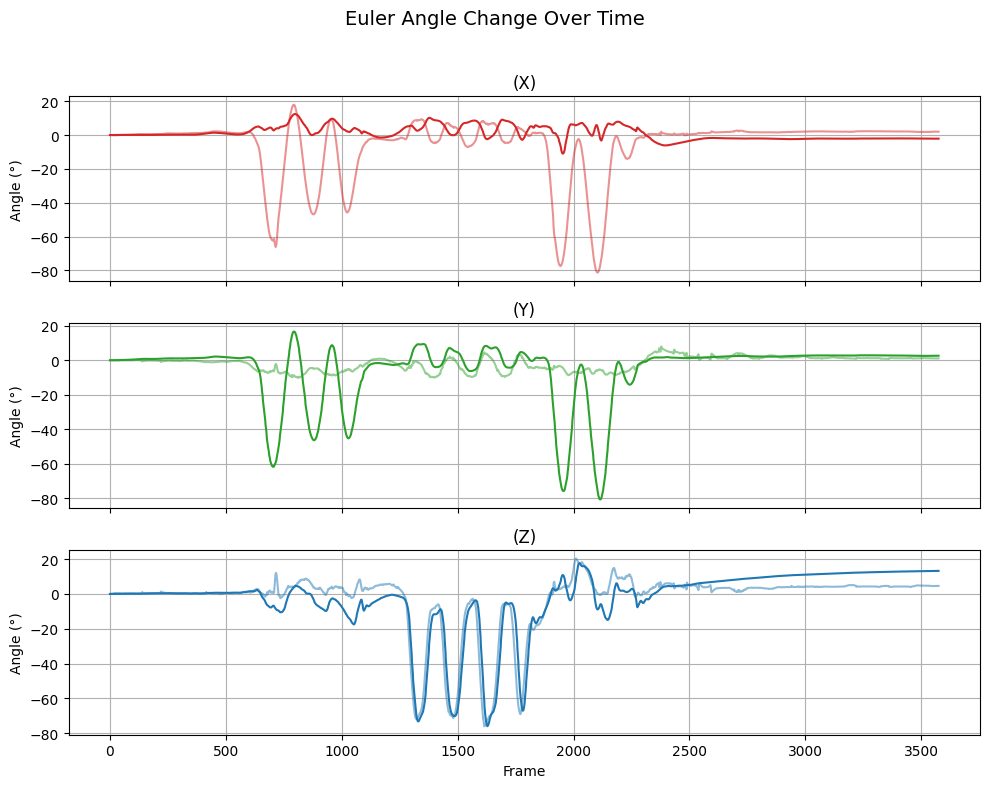

In [ ]:
# Original indices for vicon data (assumed uniform sampling)
orig_indices = np.linspace(0, 1, vicon_euler_angles.shape[0])

# Target indices for interpolation
target_len = euler_angles.shape[0]
target_indices = np.linspace(0, 1, euler_angles.shape[0])

# Interpolate each Euler angle axis separately
vicon_interp = np.zeros((target_len, 3))

for i in range(3):
    f = interp1d(orig_indices, vicon_euler_angles[:, i], kind='linear')
    vicon_interp[:, i] = f(target_indices)

print("Upsampled shape:", vicon_interp.shape)  # Should be (3000, 3)


# Create 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i in range(3):
    f = 1
    # if i ==1 or i==2:
    #     f = -1

    axes[i].plot(time, f * euler_angles[:, i], color=colors[i], label="IMU")
    axes[i].plot(time, vicon_interp[:, i], color=colors[i], alpha = 0.5, label="Vicon")
    vicon_euler_angles
    axes[i].set_ylabel("Angle (°)")
    axes[i].set_title(angle_labels[i])
    axes[i].grid(True)

axes[-1].set_xlabel("Frame")
plt.suptitle("Euler Angle Change Over Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()